In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json


In [6]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load stopwords
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [7]:

stack = joblib.load('../../Models/70-30 Test/pipeline_mlp.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']

Metrics for MNB:
Accuracy: 0.7508305647840532
Precision: 0.6696428571428571
Recall: 0.9933774834437086
F1 Score: 0.8
AUC: 0.9493598233995585
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.51      0.67       150
           1       0.67      0.99      0.80       151

    accuracy                           0.75       301
   macro avg       0.83      0.75      0.73       301
weighted avg       0.83      0.75      0.74       301



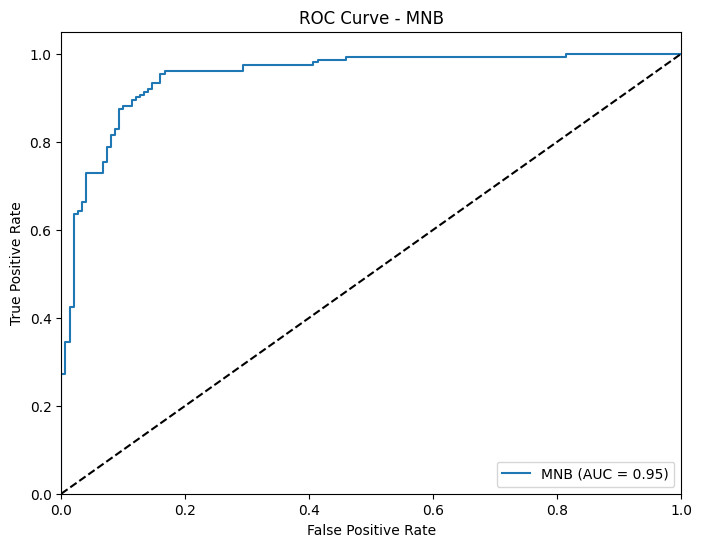

Metrics for LR:
Accuracy: 0.5913621262458472
Precision: 1.0
Recall: 0.18543046357615894
F1 Score: 0.3128491620111732
AUC: 0.9550110375275938
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       150
           1       1.00      0.19      0.31       151

    accuracy                           0.59       301
   macro avg       0.77      0.59      0.51       301
weighted avg       0.78      0.59      0.51       301



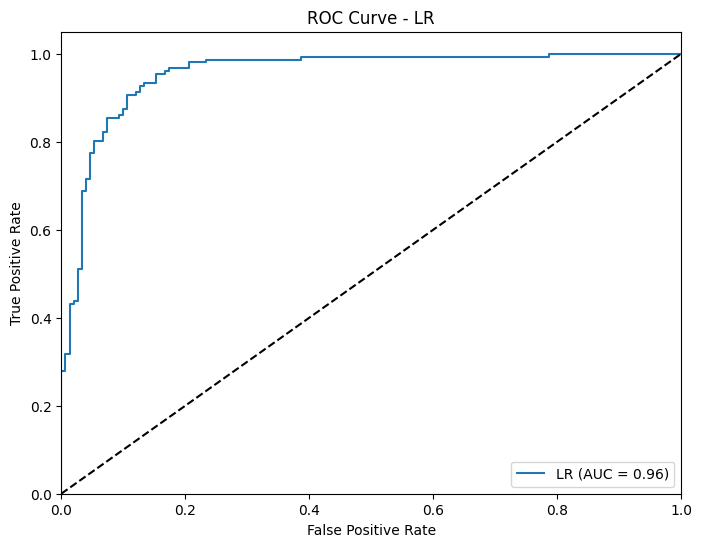

Metrics for RF:
Accuracy: 0.8305647840531561
Precision: 0.9807692307692307
Recall: 0.6754966887417219
F1 Score: 0.8
AUC: 0.9652759381898457
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       150
           1       0.98      0.68      0.80       151

    accuracy                           0.83       301
   macro avg       0.87      0.83      0.83       301
weighted avg       0.87      0.83      0.83       301



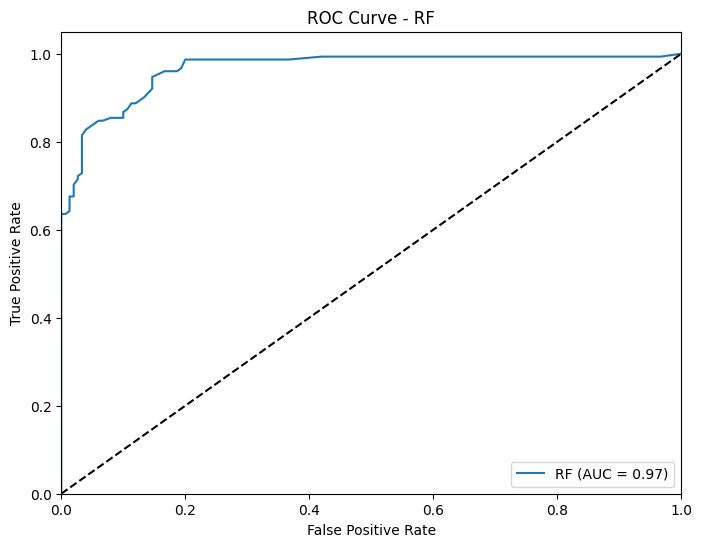

Metrics for KNN:
Accuracy: 0.717607973421927
Precision: 0.6918604651162791
Recall: 0.7880794701986755
F1 Score: 0.7368421052631579
AUC: 0.7952759381898454
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       150
           1       0.69      0.79      0.74       151

    accuracy                           0.72       301
   macro avg       0.72      0.72      0.72       301
weighted avg       0.72      0.72      0.72       301



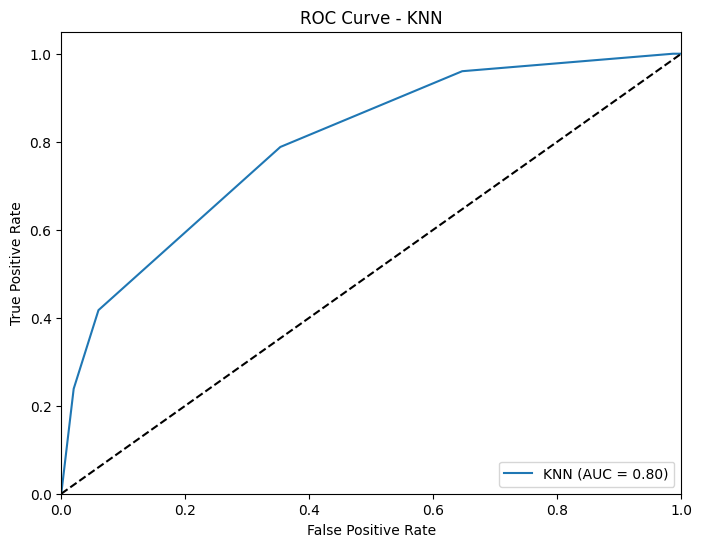

Metrics for SVM:
Accuracy: 0.5681063122923588
Precision: 1.0
Recall: 0.1390728476821192
F1 Score: 0.2441860465116279
AUC: 0.9646799116997792
Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       150
           1       1.00      0.14      0.24       151

    accuracy                           0.57       301
   macro avg       0.77      0.57      0.47       301
weighted avg       0.77      0.57      0.47       301



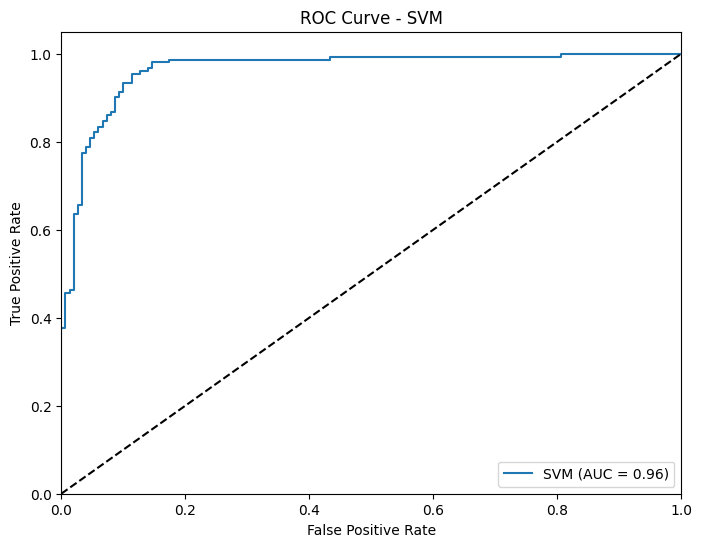

Metrics for Stacking Model:
Accuracy: 0.946843853820598
Precision: 0.9299363057324841
Recall: 0.9668874172185431
F1 Score: 0.948051948051948
AUC: 0.9820309050772627
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       150
           1       0.93      0.97      0.95       151

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



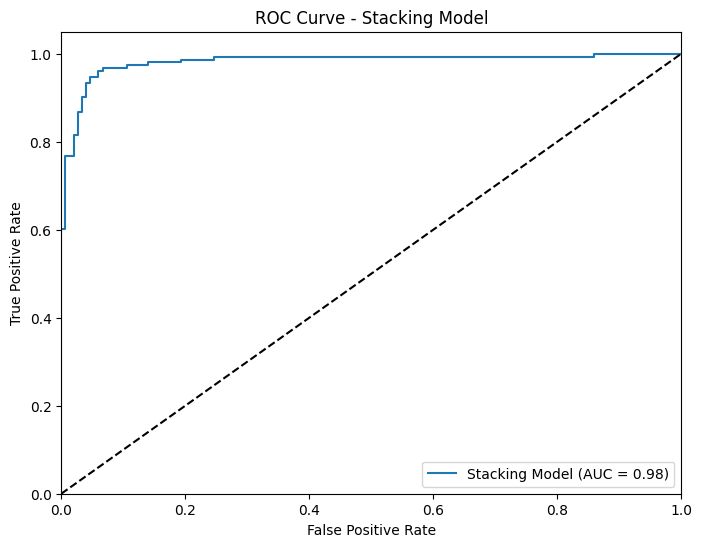

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.750831  0.669643  0.993377       0.8   0.94936
LR              0.591362       1.0   0.18543  0.312849  0.955011
RF              0.830565  0.980769  0.675497       0.8  0.965276
KNN             0.717608   0.69186  0.788079  0.736842  0.795276
SVM             0.568106       1.0  0.139073  0.244186   0.96468
Stacking Model  0.946844  0.929936  0.966887  0.948052  0.982031


In [8]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [9]:
best_meta = joblib.load('../../Models/70-30 Test/pipeline_mlp_best_estimator.joblib')
print(best_meta)

MLPClassifier(activation='logistic', learning_rate='adaptive')
